To notepad αυτό αποτελεί ένα "hello-world" για την χρήση της βιβλιοθήκης [mOWL](https://mowl.readthedocs.io/en/latest/index.html). Ο σκοπός είναι να στηθεί ένα απλό παράδειγμα που επιδεικνύει τη χρήση της mOWL για την αναγνώριση "ακμών" ενός γράφου γνώσης (ΓΓ).

**Προσοχή: Eάν το notebook τρέχει στο google colab, πρέπει να επιλεχθεί από το menu, η επιλογή Runtime -> Change runtime type και να επιλεχθεί ένα διαθέσιμο GPU. Αυτό γίνεται γιατί τα μοντέλα τρέχουν με χρήση CUDA, για γρηγορότερο χρόνο εκπαίδευσης** </h5>

In [3]:
!pip install mowl-borg

  Using cached mowl_borg-1.0.1-py3-none-any.whl.metadata (4.8 kB)
  Using cached JPype1-1.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
  Using cached pykeen-1.11.0-py3-none-any.whl.metadata (85 kB)
  Using cached temp-2020.7.2.tar.gz (1.4 kB)
  Preparing metadata (setup.py) ... done
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached click_default_group-1.2.4-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached optuna-4.2.1-py3-none-any.whl.metadata (17 kB)
  Using cached more_click-0.1.2-py3-none-any.whl.metadata (4.3 kB)
  Using cached pystow-0.7.0-py3-none-any.whl.metadata (17 kB)
  Using cached docdata-0.0.4-py3-none-any.whl.metadata (13 kB)
  Using cached class_resolver-0.5.4-py3-none-any.whl.metadata (14 kB)
  Using cached torch_max_mem-0.1.3-py3-none-any.whl.metadata (7.4 kB)
  Using cached torch_ppr-0.0.8-py3-none-any.whl.metadata (9.3 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux201

## Αρχικοποίηση
Αρχικά εισάγεται η βιβλιοθήκη mowl και η torch
και αρχικοποιείται η διαθέσιμη προς χρήση μνήμη για το Java Virtual Machine ως 10 Gigabytes. <br>
Η βιβλιοθήκη [mOWL](https://mowl.readthedocs.io/en/latest/) είναι μια βιβλιοθήκη που έχει σχεδιαστεί για να υποστηρίζει τη Μηχανική Μάθηση με Οντολογίες, προσφέροντας λειτουργίες για τη διαχείριση οντολογιών και τη δημιουργία αναπαραστάσεων σε μορφή διανυσμάτων (embeddings) για τις οντότητες τους. Αξιοποιεί την [OWLAPI](https://github.com/owlcs/owlapi/wiki/Documentation), μια βιβλιοθήκη γραμμένη σε Java, μέσω του JPype και για αυτό τον λόγο είναι αναγκαία και η αρχικοποίηση μνήμης στο JVM.
Η [Torch](https://pytorch.org/docs/stable/index.html) παρέχει ισχυρά εργαλεία για την εκπαίδευση και τη χρήση αλγορίθμων μηχανικής μάθησης και νευρωνικών δικτύων.

In [4]:
import mowl
mowl.init_jvm("10g")
import torch as th

### Dataset που χρησιμοποιείται:
Το dataset που χρησιμοποιείται είναι το [PPIYeastDataset](https://mowl.readthedocs.io/en/latest/api/mowl.datasets.builtin.PPIYeastDataset.html#mowl.datasets.builtin.PPIYeastDataset) το οποίο είναι built-in στη βιβλιοθήκη mowl. Το dataset αυτό περιλαμβάνει protein-protein interactions που αφορούν τον συγκεκριμένο μύκητα και οι σχέσεις μεταξύ πρωτεϊνών αναπαραστούνται σαν αξιώματα με τον παρακάτω τρόπο: <br>
<b>protein1 ⊆ interacts_with.protein2</b>
Το dataset αποθηκέυεται σε έναν φάκελο με 3 αρχεία τύπου "*.owl" κατά την εκτέλεση του προγράμματος. Στον φάκελο αυτό περιέχονται τα εξής: "ontology.owl" το οποίο εισάγεται σαν είσοδος στο στάδιο εκπαίδευσης των μοντέλων, "valid.owl" για την επικύρωση του μοντέλου (παραγωγή κάποιου loss) στα στάδια της εκπαίδευσης και "test.owl" για την τελική αξιολόγηση των embeddings. <br>
Η δομή του dataset αποτελείται κυρίως από κλάσεις στην owl (πχ http://4932.Q0045 , όπου το 4932.Q0045 είναι το identifier της πρωτείνης), αν ανήκει κάπου σε ποιά ευρύτερη κατηγορία κλάσεων προτείνων (subClassOf), διάφορα restrictions, ιδιότητες και κυρίως properties, όπως και το αντικείμενο κορμού στην μελέτη PPI, interacts_with που συνδέει 2 κλάσεις πρωτεινών μεταξύ τους.


## EL-embedding μοντέλο
H mOWL μπορεί να παράξει embeddings με πολλούς τρόπους. Το [EL-embedding μοντέλο](https://mowl.readthedocs.io/en/latest/examples/elmodels/plot_1_elembeddings.html#sphx-glr-examples-elmodels-plot-1-elembeddings-py), είναι ένας από αυτούς.
Το [EL profile](https://www.w3.org/TR/owl2-profiles/#OWL_2_EL), είναι ένα lightweight profile της OWL που υποστηρίζει βασικές εκφράσεις Descriptions Logic, καθιστώντας το ιδιαίτερα χρήσιμο για μεγάλα datasets με απλές ιεραρχίες.

Το EL profile βασίζεται στα εξής General Concept Inclusions (GCIs):

**GCI 0** - `C ⊑ D`: Περιγράφει ότι κάθε στοιχείο της κλάσης 𝐶 ανήκει και στην κλάση D. Ουσιαστικά, είναι η σχέση "subclassOf" της OWL.<br>
**GCI 1** - `C1 ⊓ C2 ⊑ D`: Περιγράφει ότι αν κάτι ανήκει στην κλάση C1 και στην κλάση C2, τότε ανήκει και στην κλάση D. To EL profile μπορεί να υποστηρίξει τομή δύο κλάσεων.<br>
**GCI 2** - `C ⊑ ∃R.D`: Περιγράφει ότι όλα τα μέλη της κλάσης C πρέπει να έχουν μια σχέση R με τουλάχιστον ένα αντικείμενο που ανήκει στην κλάση D. Το EL profile μπορεί να υποστηρίξει σχέσεις (properties) μεταξύ κλάσεων και individuals.<br>
**GCI 3** - `∃R.C ⊑ D`: Περιγράφει ότι αν υπάρχει μια σχέση R που συνδέει κάποιο αντικείμενο με ένα μέλος της κλάσης C, τότε το αντικείμενο αυτό ανήκει στην κλάση D.<br>
**GCI bot 0** - `C ⊑ ⊥`: Περιγράφει ότι δεν υπάρχει κάποιο αντικείμενο στην κλάση C - μπορεί να υπάρξει κενή κλάση.<br>
**GCI bot 1** - `C1 ⊓ C2 ⊑ ⊥`: Περιγράφει ότι μπορεί η τομή των κλάσεων C1 και C2 να είναι κενή<br>
**GCI bot 3** - `∃R.C ⊑ ⊥`: Περιγράφει ότι δεν υπάρχει αντικείμενο που να έχει μια σχέση R προς κάτι που ανήκει στην κλάση C.<br>

όπου τα C1, C2, D είναι κλάσεις, το R αντιστοιχεί σε μια ιδιότητα.
Ουσιαστικά, τα GCIs αποτυπώνουν τους "κανόνες" που μπορούμε να χρησιμοποιήσουμε για να περιγράψουμε γνώση με το συγκεκριμένο OWL profile.

Σύμφωνα με το σχετικό [paper](https://www.ijcai.org/proceedings/2019/845), το EL embedding μοντέλο αποσκοπεί στο να μεταφέρει τις κλάσεις και τις σχέσεις σε μια γεωμετρική διάσταση (όπως έναν n-διάστατο πραγματικό χώρο). Ο στόχος είναι να διατηρηθεί η σημασιολογική δομή της οντολογίας μέσα σε αυτόν τον γεωμετρικό χώρο.
Για να επιτευχθεί αυτό η mOWL αντιστοιχίζει κάθε κλάση σε μια n-διάστατη σφαίρα ("μπάλα"). Αν καταλαβαίνω καλά, η n-μπάλα που αντιστοιχεί στην κλάση C1 περικλείει όλα τα individuals της κλάσης. Κάθε σημείο της "υπερσφαίρας" αυτής αποτελεί ένα από τα individuals της κλάσης. Με αυτή τη λογική, αν μια κλάση είναι υποκλάση μιας άλλης, η αντίστοιχη n-μπάλα που αναπαριστά την πρώτη κλάση (υποκλάση) θα πρέπει να βρίσκεται μέσα στην n-μπάλα της δεύτερης (υπερκλάση).

Οι σχέσεις μεταξύ κλάσεων (object properties) αντιστοιχίζονται σε διανύσματα σε αυτόν τον n-διάστατο χώρο. Ας υποθέσουμε ένα object property P που διασυνδέει τα individuals c της κλάσης C και d της κλάσης D. Αυτή η σχέση θα αποτυπωθεί στον διανυσματικό χώρο του μετασχηματισμού σαν ένα διάνυσμα που ενώνει δύο σημεία τα οποία περικλείονται από τις αντίστοιχες n-μπάλες που αποτελούν τον μετασχηματισμό της κλάσης C και της κλάσης D.

Το μοντέλο εκμάθησης χρησιμοποιεί συναρτήσεις απώλειας για να διασφαλίσει ότι η γεωμετρική αναπαράσταση της οντολογίας διατηρεί τις λογικές σχέσεις μεταξύ των κλάσεων και των σχέσεων.
Ορίζεται λοιπόν για κάθε ένα GCI μια συνάρτησης απώλειας και το άθρισμα των απωλειών για κάθε μετασχηματισμό κάθε μιας από τις κλάσεις χρησιμοποιείται για την δυνατόν καλύτερη προσαρμογή των σφαιρών στους κανόνες του EL Profile.  

Ως παράδειγμα, υπάρχει ένα μοντέλο που χρησιμοποιείται για να μοντελοποιήσει τις σχέσεις των PPIs. Το μοντέλο αυτό είναι ένα μοντέλο τύπου EL-embedding ([ELEmPPI](https://mowl.readthedocs.io/en/latest/_modules/mowl/models/elembeddings/examples/model_ppi.html#ELEmPPI)) αλλά παρέχεται και ένα γενικότερο μοντέλο που μπορεί να προσαρμοστεί για οποιοδήποτε dataset. <br>



## Εκπαίδευση μοντέλου EL embedding
Στις παραμέτρους του ELEmPPI μπορούν να δοκιμαστούν διάφορες τιμές για κάθε όρισμα. <br>
Η έξοδος μετά την εκπέδευση, αποθηκέυται στις τιμές model.class_embeddings και model.object_property_embeddings και είναι τυπου dictionaries. Το  model.class_embeddings περιέχει τα ονόματα των κλάσεων και το embedding τους, και το model.object_property_embeddings τις ιδιότητες με τα αντίστοιχα embeddings για την κάθε μία από αυτές.

In [5]:
import logging
from mowl.datasets.builtin import PPIYeastDataset
from mowl.models import ELEmPPI

# logging να αγνοεί τα info μηνύματα
logging.basicConfig(level=logging.WARNING)

# dataset που χρησιμοποιείται (το συγκεκριμένο είναι built-in)
dataset = PPIYeastDataset()

# initialize model with the required parameters
model = ELEmPPI(dataset, #το dataset που χρησιμοποιείται για εκπέδευση (στο συγκεκριμένο μέσα στο ELemPPI παίρνει το training κομμ΄άτι του και τα GCIs αυτού
                embed_dim=50, #διάσταση των embedding
                learning_rate=0.001,#ρυθμός μάθησης (ρυθμός ενημέρωσης παραμέτρων εκπέδευσης σε κάθε βήμα)
                epochs=100,#αριθμός εποχών (δλδ πλήρης επαναλήψεων εκπέδευσης)
                batch_size=20000, #τα δείγματα που επεξεργάζονται σε κάθε βήμα
                model_filepath=None,
                device='cuda') #Χρήση cuda (gpu) για γρηγορότερους υπολογισμούς στο training

#κλήση μεθόδου εκπέδευσης
model.train()


INFO:pykeen.utils:Using opt_einsum
100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


1

## Evaluation

To evaluation των embeddings διαφέρει ανάλογα με το dataset. Στο συγκεκριμένο παράδειγμα, χρησιμοποιείται το PPIYeastDataset και το built-in [PPIEvaluator](https://mowl.readthedocs.io/en/latest/api/mowl.evaluation.PPIEvaluator.html#mowl.evaluation.PPIEvaluator). <b> Κάθε κλάση Evaluator χαρακτηρίζεται από δύο κύρια σημεία: τον τύπο των οντοτήτων που εμπλέκονται και τον τύπο των αξιωμάτων που θα αξιολογηθούν. </b> Στην περίπτωση του PPIEvaluator, οι εμπλεκόμενες οντότητες είναι μόνο αυτές που εκπροσωπούν πρωτεΐνες, χωρίς να λαμβάνονται υπόψη άλλες οντότητες. Τα αξιώματα που αξιολογούνται με τον PPIEvaluator είναι του τύπου "p1 αλληλεπιδρά με p2" (εξού και το PPI όνομα). Κάθε dataset έχει τη δική του ιδιότητα evaluation_classes, όπου καθορίζει τι είδους οντότητες ή αξιώματα θα εξεταστούν από το dataset στο πλαίσιο της αξιολόγησης. <br>
Ουσιαστικά, συγκρίνοντας την ομοιότητα μεταξύ των κλάσεων στον n-χώρο (semantic similarity), και υποθέτοντας πως όσο πιο όμοιες είναι 2 κλάσεις τόσο πιο πιθανό είναι να αλληλεπιδρούν, μετά συγκρίνοντας τα αποτελέσματα με πραγματικά (h,r,t) δεδομένα, όπου r είναι η ιδιότητα "interacts_with", είναι δυνατόν να αξιολογήσουμε την ακρίβεια του μοντέλου. Για παράδειγμα, παίρνοντας τα 10 πρώτα αποτελέσματα με την μεγαλύτερη ομοιότητα μεταξύ μιας κλάσης με οποιαδήποτε άλλη, και συγκρίνοντας τα με το αν πραγματικά υπάρχει interaction μεταξύ του head και κάποιου tail, υπολογίζεται το hits@10 για την κλάση αυτή.

In [8]:
from mowl.evaluation import PPIEvaluator
model.set_evaluator(PPIEvaluator)
model.evaluate(dataset.testing)

data1 = model.metrics #αποθήκευση αποτελεσμάτων για το ELembedding
print(data1)

{'mr': 1323.3686877076411, 'mrr': 0.005869988385082, 'f_mr': 1323.3686877076411, 'f_mrr': 0.005869988385082, 'auc': 0.7809922676867106, 'f_auc': 0.7809922676867106, 'hits@1': 0.0, 'hits@3': 0.0031561461794019936, 'hits@10': 0.009966777408637873, 'hits@50': 0.04443521594684385, 'hits@100': 0.08679401993355482, 'f_hits@1': 0.0, 'f_hits@3': 0.0031561461794019936, 'f_hits@10': 0.009966777408637873, 'f_hits@50': 0.04443521594684385, 'f_hits@100': 0.08679401993355482}


### Οπτικοποίηση αποτελεσμάτων ###

Για την απεικόνιση των embedding, η έτοιμη κλάση TSNE της mowl, δεν είναι επαρκής, καθώς δεν αναφέρει το όνομα της κάθε κλάσης κάτω από τις βούλες στην αναπαράσταση, και χρησιμοποιεί ένα legend. Παρόλα αυτά, όταν έχουμε πολλές διαφορετικές κλάσεις, όπως και με τα PPI, όπου κάποιες αναγκαστικά θα έχουν το ίδιο χρώμα, το legend είναι απρόσφορο.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


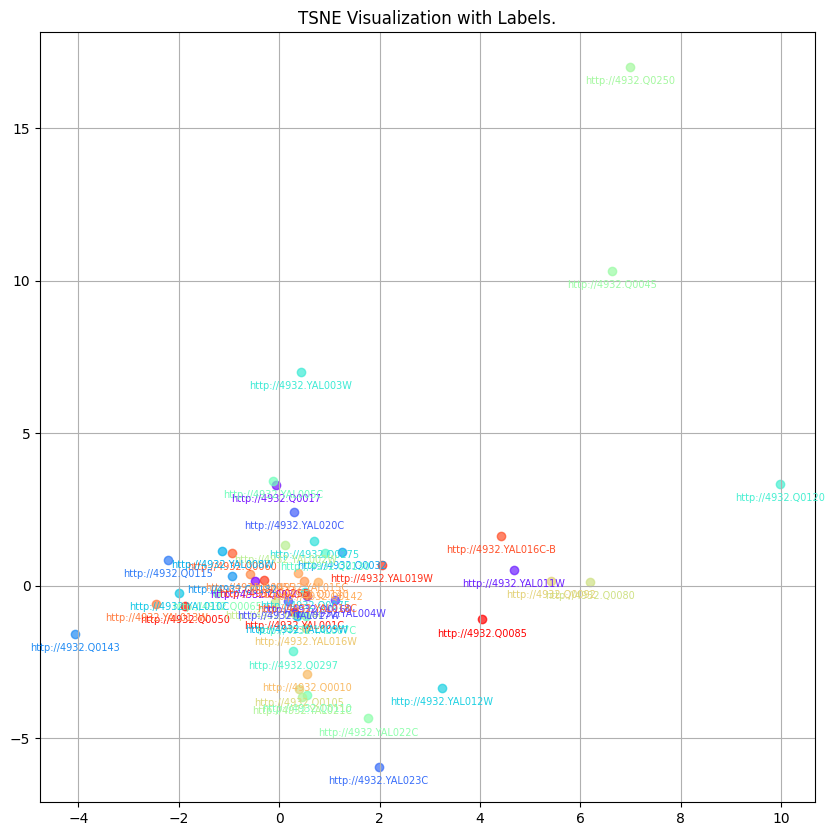

In [10]:

import matplotlib.pyplot as plt
from mowl.visualization import TSNE

class CustomTSNE(TSNE):
    def show(self, figsize=(10, 10), alpha=0.5, fontsize=9):
        """Modified show function to display text labels behind points."""
        points = self.points
        labels = self.labels

        if points is None:
            raise ValueError("You need to call generate_points() first.")

        plt.figure(figsize=figsize)

        for i, label in enumerate(labels):
            #color = label_to_color[label]
            color = self.class_color_dict[label]
            plt.scatter(points[i, 0], points[i, 1], color=color, alpha=0.7) #alpha= opacity
            plt.text(points[i, 0], points[i, 1] - 0.3, label, fontsize=7,  #fontisze = label size
                     ha='center', va='top', color=color)                    #  points[i,1]-0.3 = change -0.3 to make the label go lower or higher

        plt.title("TSNE Visualization with Labels.")
        plt.grid(True)
        plt.show()



class_embeddings = model.class_embeddings #dict με ονόματα κλάσεων δλ΄δ προτεινών και το αντίστοιχο embedding τους.
#για το plot χρησιμοποιούνται τα 50 πρώτα classes
limited_class_embeddings = dict(list(model.class_embeddings.items())[:50])
res = dict((k,k) for k,v in limited_class_embeddings.items())
tsne = CustomTSNE(limited_class_embeddings, res) #εργαλείο για μείωση των διαστάσεων σε 2, για λόγους οπτικοποίησης
tsne.generate_points(250, workers=4)
tsne.show()


## ELBox Embedding
Στην περίπτωση των EL Embeddings, τα γεωμετρικά αντικείμενα που αναπαριστούν τις κλάσεις της οντολογίας είναι μπάλες n-διαστάσεων. Ένα από τα GCI στην EL είναι: <br>
`C1 ⊓ C2 ⊑ D'
Όπως είναι φανερό, σε αυτό το GCI, υπάρχει μια πράξη τομής . Η υπολογιστική αυτή τομή χρησιμοποιώντας μπάλες δεν είναι μια κλειστή πράξη διότι η περιοχή που περιέχεται στην τομή δύο μπαλών δεν είναι μπάλα. Για να λυθεί αυτό το ζήτημα, μπορεί να χρησιμοποιηθεί ένας άλλος τρόπος να παράξουμε embeddings ο οποίος αντί για n-μπάλες μετατρέπει τις κλάσεις σε n-κύβους για τους οποίους η πράξη της τομής έχει την ιδιότητα της κλειστότητας. Aυτό γίνεται με το έτοιμο μοντέλο [ELBoxPPI](https://mowl.readthedocs.io/en/latest/_modules/mowl/models/elboxembeddings/examples/model_ppi.html#ELBoxPPI) της mowl, αντιστοίχως.


In [14]:
from mowl.models.elboxembeddings.examples.model_ppi import ELBoxPPI
model = ELBoxPPI(dataset,
                 embed_dim=50,
                 learning_rate=0.001,
                 epochs=100,
                 batch_size=20000,
                 model_filepath=None,
                 device='cuda')
model.train()

100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


1

Εδώ χρησιμοποιείται για άλλη μια φορά το built-in evaluator για PPIs της mowl και αποθηκεύονται τα αποτελέσματα απόδοσης του embedding.

In [15]:
from mowl.evaluation import PPIEvaluator

model.set_evaluator(PPIEvaluator)
model.evaluate(dataset.testing)
data2= model.metrics
print(data2)

{'mr': 1307.8099667774086, 'mrr': 0.005416636937179751, 'f_mr': 1307.8099667774086, 'f_mrr': 0.005416636937179751, 'auc': 0.7835690681057621, 'f_auc': 0.7835690681057621, 'hits@1': 0.0, 'hits@3': 0.00132890365448505, 'hits@10': 0.007973421926910298, 'hits@50': 0.04410299003322259, 'hits@100': 0.0882890365448505, 'f_hits@1': 0.0, 'f_hits@3': 0.00132890365448505, 'f_hits@10': 0.007973421926910298, 'f_hits@50': 0.04410299003322259, 'f_hits@100': 0.0882890365448505}


## Embedding με χρήση γράφου
### TransE Embedding
Η αποτύπωση μίας οντολογίας σε μορφή γράφου, διευρύνει κατά πολύ τις μεθοδολογίες που μπορούν να χρησιμοποιηθούν για την παραγωγή embeddings, όπως η χρήση random walks και αλλων KGE μεθόδων, διατειρώντας την σημασιολογία μεταξύ κλάσεων και σχέσεων.
Στο παράδειγμα αυτό, αρχικά το dataset προβάλλεται σε γράφο με χρήση του [DL2VecProjector](https://mowl.readthedocs.io/en/latest/api/mowl.projection.DL2VecProjector.html#mowl.projection.DL2VecProjector). H προβολή αυτή, ουσιαστικά παράγει [τριπλέτες για το pyKEEN μοντέλο](https://mowl.readthedocs.io/en/stable/api/mowl.projection.Edge.html#mowl.projection.Edge), ιδανικές δηλαδή για χρήση TransE embedding.<br>
Tο [TransE](https://arxiv.org/pdf/2406.10964) αντιπροσωπεύει τις οντότητες (ℎ, 𝑡) και τις σχέσεις (𝑟) ενός γράφου γνώσης ως διανύσματα στον ίδιο χώρο. Ο βασικός στόχος του TransE είναι να μοντελοποιήσει τις σχέσεις μεταξύ των οντοτήτων ως μετατοπίσεις στον χώρο. Ουσιαστικά η εξίσωση που προσπαθεί να λύσει είναι η εξής: ℎ+𝑟≈𝑡 <br>

In [ ]:
from mowl.models import GraphPlusPyKEENModel
from mowl.projection import DL2VecProjector
from pykeen.models import TransE

model = GraphPlusPyKEENModel(dataset,device='cuda')
model.set_projector(DL2VecProjector()) #προβολή του dataset σε γράφο
model.set_kge_method(TransE, random_seed=42) #χρηση του transE για την παραγωγη embedding στον γράφο γνώσης
model.optimizer = th.optim.Adam
model.lr = 0.001
model.batch_size = 32

model.train(epochs = 20) #εκπέδευση μοντελου





Evaluation μοντέλου με χρήση του PPIEvaluator (εξηγήθηκε παραπάνω) και αποθήκευση μετρικών απόδοσης.

In [ ]:
model.set_evaluator(PPIEvaluator)
model.evaluate(dataset.testing)
data3= model.metrics

## Συνακτικα μοντελα
### OPA2Vec  <br>
Για τα συνακτικά μοντέλα, απαραίτητη είναι η αναπαράσταση των αξιωμάτων σε μορφή text, ώστε στην συνέχεια με την χρήση ενός μοντέλου όπως το [Word2Vec](https://mowl.readthedocs.io/en/stable/api/mowl.models.SyntacticPlusW2VModel.html#mowl.models.SyntacticPlusW2VModel),για να παραχθούν τα embedding. Στο συγκεκριμένο παράδειγμα, χρησιμοποιούνται και reasoners για να δημιουργηθούν και αξιώματα υποκλάσης και εξίσωσης κλάσεων. Επιπλέον, χρησιμοποιείται άτυπη γνώση όπως μεταδεδομένα οντοτήτων (πχ συνώνημα, ορισμοί) με την χρήση του "extract_and_save_annotation_corpus" της [mowl.corpus](https://mowl.readthedocs.io/en/stable/api/corpus/index.html), όπου είναι και η διαφορά του μοντέλου από το [Onto2Vec](https://mowl.readthedocs.io/en/stable/examples/syntactic/plot_1_onto2vec.html#sphx-glr-examples-syntactic-plot-1-onto2vec-py).


In [ ]:
from mowl.corpus import extract_and_save_axiom_corpus, extract_and_save_annotation_corpus
from mowl.owlapi import OWLAPIAdapter
from mowl.reasoning import MOWLReasoner
from org.semanticweb.elk.owlapi import ElkReasonerFactory
from java.util import HashSet
from mowl.models import SyntacticPlusW2VModel
import os
logging.basicConfig(level=logging.WARNING)
reasoner_factory = ElkReasonerFactory()
reasoner = reasoner_factory.createReasoner(dataset.ontology)
mowl_reasoner = MOWLReasoner(reasoner)

classes = dataset.ontology.getClassesInSignature()
subclass_axioms = mowl_reasoner.infer_subclass_axioms(classes) #αξιωματα υποκλάσεων
equivalent_class_axioms = mowl_reasoner.infer_equivalent_class_axioms(classes) #αξιωματα εξισωσης κλάσεων

adapter = OWLAPIAdapter()
manager = adapter.owl_manager

axioms = HashSet()
axioms.addAll(subclass_axioms)
axioms.addAll(equivalent_class_axioms)

manager.addAxioms(dataset.ontology, axioms) #προσθηκη των αξιωματων που παρηχθηκαν απο το reasoner στην οντολογία που χρησιμοποιείται

extract_and_save_axiom_corpus(dataset.ontology, "opa2vec_corpus.txt") #αποθηκευση ολων των αξιωματων που υπηρχαν και παράχθηκαν σε μορφη text
extract_and_save_annotation_corpus(dataset.ontology, "opa2vec_corpus.txt", mode="a") #επεκταση text με μεταδεδομένα όπως ορισμοί και περιγραφές στιγμιοτύπων


model = SyntacticPlusW2VModel(dataset, corpus_filepath="opa2vec_corpus.txt") #Word2Vec στο text για παραγωγη embedding
model.set_w2v_model(min_count=1, workers=4, epochs=20)
model.generate_corpus(save=True, with_annotations=True)
model.train()
os.remove("opa2vec_corpus.txt")


## Evaluation του OPA2Vec
Για άλλη μια φορά χρησιμοποείται το PPIEvaluator όπως και πάνω.

In [ ]:
model.set_evaluator(PPIEvaluator)
model.evaluate(dataset.testing)
data4= model.metrics


### Ευνοϊκή για σύγκριση αναπαράσταση αποδόσεων των μοντέλων με χρήση DataFrame της βιβλιοθήκης pandas.

In [ ]:
import pandas as pd
df = pd.DataFrame([data1, data2, data3,data4], index=['Model 1', 'Model 2', 'Model 3', 'Model 4'])

pd.set_option('display.float_format', lambda x: f'{x:.6f}') #δεκαδική μορφή
print(df)